<small><small><i>
All of these python notebooks are available at [ https://github.com/milaan9/Python4DataScience ]
</i></small></small>

## Network Examples

Two basic python libraries that allow dealing with graphs are `networkx` and `graphviz`. The second of these is fairly small and really just for visualising graphs (see [graphviz documentation](http://graphviz.readthedocs.io/en/stable/) for details). 

*Note:* If either of these libraries is not installed on your own computer may need to use `conda install graphviz python-graphviz networkx` using the Anaconda commandline.

The `networkx` library has an extensive set of graph algorithms implemented for graphs, directed graphs and multigraphs (graphs/networks with parallel edges). Note that the aim of this is mainly to provide "ease of use" rather than efficiency, so everything is stored in dictionaries. For example, each edge has a data dictionary associated with it. To store the upper bound and capacity for this, it is necessary to store something like 
`data={"capacity":3, "weight": 5.5}` to specify that the edge has an upper bound of 3 on flow, and a cost of 5. This is not very efficient. In fact the first thing any of the algorithm implementations do is to map all data back to lists! Also, while the library doesn't specifically prohibit it, it generally doesn't handle floating point values very well (no allowance for $\epsilon$ differences that can occur due to numerical errors). 

Hence the `networkx` library is useful for validating any code you write, but it is expected that normally it will be possible with a little effort to create better performing methods for any of the algorithms in this library. For more information about the library see the [networkx documentation](https://networkx.github.io/documentation/stable/index.html). 

### Creating and displaying a random graph
Here we create a random graph and provide a small utility function that converts a networkx graph object to the corresponding graphviz object for the purposes of diplaying it.

Some useful methods for graph objects from the networkx library include
  * `G.nodes_iter()` iterates over all nodes in the graph object G. Nodes are usually indexed by integers from 0.
  * `G.edges_iter()` returns (tail,head) pairs for each edge in the graph object G. Optionally you can use `G.edges_iter(data=True)` to get (tail,head,dataDictionary) objects.
  * `G.out_edges_iter(n)`, `G.in_edges_iter(n)` and `G.edges_iter(n)` iterates over the edges pointing out, in and all edges attached to node `n` respectively. Again these iterators return (tail,head) or (tail,head,data) tuples
  * All of the above methods have an equivalent method without the `_iter` in the name which simply return a list. So `G.nodes()` is equivalent to `[n for n in G.nodes_iter()]`
 
The networkx library handles parallel edges - but this was clearly an afterthought and is not done well. It changes the data type from `DiGraph` to `MultiDiGraph` and there is no easy way to refer to one of a set of parallel edges.


In [2]:
import networkx as nx
import graphviz
def nx2gv(net,nodeLabel={},edgeLabel={},edgeSet={},nodeSet={}):
    """Convert networkx.DiGraph to graphviz.Digraph for visualisation.
    Optionally include labels (values) for nodes, arcs & sets to highlight"""
    g = graphviz.Digraph()
    for nd in net.nodes_iter():
        g.node(str(nd),str(nd)+(":"+str(nodeLabel[nd]) if nd in nodeLabel else ""),
               color=("red" if nd in nodeSet else "black"))
    for tail,head in net.edges_iter():
        col=("red" if (tail,head) in edgeSet else "black")
        if (tail,head) in edgeLabel:
            g.edge(str(tail),str(head),str(edgeLabel[tail,head]),color=col)
        else:
            g.edge(str(tail),str(head),color=col)
    return g

net with 7 nodes & 15 edges


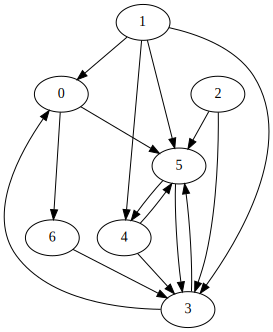

In [3]:
# create a random graph with n nodes and probability p of arc between nodes
net = nx.binomial_graph(7,0.4,directed=True)
print("net with %d nodes & %d edges"%(net.number_of_nodes(),net.number_of_edges()))
nx2gv(net)

### Using the Networkx graph algorithms
Here is an example of a graph algorithm (shortest path). We need to store the data on arc lengths in each edge dictionary and then run the algorithm. Aftewards the utility function is used to display the graph together with the distance labels. The code also highlights the edges in the shortest path tree and the set of reachable nodes.

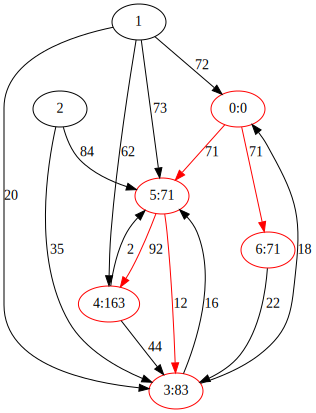

In [4]:
# set some random data
import random
for frm,to,data in net.edges_iter(data=True): 
    data["weight"]=random.randint(1,99)  # create random edge weight in {1,2,...,99}
dist = nx.shortest_path_length(net,0,weight="weight") # from node 0 to all others
# Now display the resulting graph
nx2gv(net,nodeLabel=dist,
      nodeSet=set(dist.keys()), # reachable nodes
      edgeSet={ (a,b) for a,b,data in net.edges_iter(data=True) 
               if a in dist and dist[a]+data["weight"]==dist[b]},
      edgeLabel={ (a,b):data["weight"] for  a,b,data in net.edges_iter(data=True)})

### CPLEX Network Simplex Method
The CPLEX library contains a very fast, network simplex method for solving network flow problems. A simple python interface to this is provided in the `mymip.mycplex` library.  The basic methods for this are
 * `N=mymip.mycplex.Network()` constructs a network object
 * `N.addNode(s)` creates a node with supply `s` and returns the node object
 * `N.addArc(a,b,lb=0,ub=10,obj=3,name='a_b')` The first two arguments must be node objects created with `addNode`. All of the arguments except the first are optional (lower and upper bound default to zero/infinity, objective to 0 and name to the empty string)
 * `N.optimise()` to solve the optimisation problem
Once the network flow problem has been solved `arc.x` and `node.x` (for node objects and arc objects) contains the primal (arc flow) and dual (node potential) information.

optimal: Sum of 4 shortest paths from node 0 is 388.0


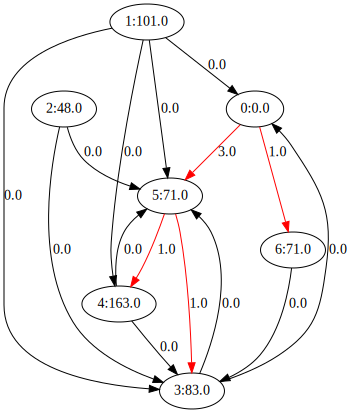

In [5]:
import mymip
N = mymip.mycplex.Network()
src=0
reachable=len(dist)-1 # number of reachable nodes
node=[N.addNode( reachable if n==src else (-1 if n in dist else 0))
      for n in net.nodes_iter()]
edge=[N.addArc(node[a],node[b],lb=0,obj=data['weight'])
      for a,b,data in net.edges_iter(data=True)]
N.optimise()
print(N.status()+": Sum of",reachable,"shortest paths from node",src,"is",N.objective())
nx2gv(net,
      nodeLabel={nd.id:(node[0].x-nd.x) for nd in node}, # node potential=distance
      edgeSet={ (e.src.id,e.to.id) for e in edge if e.x > 0},
      edgeLabel={ (e.src.id,e.to.id):e.x for  e in edge}) # flow on each edge